# Project 3
The initial exploratory data analysis (EDA) of the em-dat data set can be viewed in Countries_Eda.ipynb.
Further analysis and testing of this data set can be seen in Eda_and_Testing.ipynb.
Finally, EDA on NASA's temperature anomaly data can be seen in tempAnomalyEda.ipynb.

In this notebook, I will combine the disaster data from em-dat with the temperature anomaly data from NASA. I will train both a neural net (using pytorch) and a tree model (using XGBoost) to attempt predictions on future costs due to climate related natural disasters.

## Option 1
- Train with all features
- Create a sub-model for prediction, where I extract the weights and biases for the features I wish to use in prediction

## Option 2
- Train only on the features to be used in prediction

## Use random forests or whatever (2 steps from lectures)
I need to use enough of whatever methods are mentioned in lectures
- One option is to compare neural net to random forests (apparently good for tabular data??)



## Solution

Set up data holder class:

In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import namedtuple

class data_holder():
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.df = self.data.copy()

    def filter_columns(self, columns_to_keep):
        self.data = self.data[columns_to_keep]

    def remove_rows_where_null(self, remove_null_rows_in_column):
        self.data = self.data.dropna(subset = remove_null_rows_in_column)

    def replace_nan_with_zero(self, replace_nan_in_columns):
        self.data[replace_nan_in_columns] = self.data[replace_nan_in_columns].fillna(0)

    def filter_values(self, column, values):
        self.data = self.data[self.data[column].isin(values)]

    def map_categories_to_numbers(self, column):
        label_encoder = LabelEncoder()

        self.data[column] = label_encoder.fit_transform(self.data[column])
        category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        print("Category Mapping:", category_mapping)

    def split_train_test(self, target_column):
        self.target = target_column
        feature_columns = self.data.columns.drop([target_column])

        self.X = self.data[feature_columns]
        self.y = self.data[target_column]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.X, self.y , random_state=104,test_size=0.20, shuffle=True)

        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def scale(self, scaler):
        # Training set
        X_train_scaled = scaler.fit_transform(self.X_train)
        y_train_scaled = scaler.fit_transform(self.y_train.values.reshape(-1, 1))

        # Test set
        X_test_scaled = scaler.fit_transform(self.X_test)
        y_test_scaled = scaler.fit_transform(self.y_test.values.reshape(-1, 1))

        return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled

        


Then clean the data:

In [2]:
disasters = data_holder('./DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv')

columns_of_interest = [ "Year", "Aid Contribution", "No Injured", "No Homeless", "Total Affected", "CPI", "Total Damages ('000 US$)", "Disaster Subgroup"]
zero_where_null_columns = ["Aid Contribution", "No Injured", "No Homeless", "Total Affected", "Disaster Subgroup"]
remove_where_null_columns = ["CPI", "Total Damages ('000 US$)"]
disaster_subgroups = [ "Meteorological", "Hydrological", "Climatological"]

#Clean data
disasters.filter_columns(columns_of_interest)
disasters.remove_rows_where_null(remove_where_null_columns)

disasters.replace_nan_with_zero(zero_where_null_columns)

disasters.filter_values('Disaster Subgroup', disaster_subgroups)

#Turn category-values into numerical values
disasters.map_categories_to_numbers("Disaster Subgroup")

Category Mapping: {'Climatological': 0, 'Hydrological': 1, 'Meteorological': 2}


Get the shape of the feature matrix to prepare for model input:

In [ ]:
print("Shape of data set after cleaning:")
print(disasters.data.shape)

disasters.data.head()

Monetary values must be adjusted according to the following formula:

In [3]:
def adjust_cost(cost, cpi):
    return (100*cost)/cpi

disasters.data["Total Damages ('000 US$)"] = adjust_cost(cost=disasters.data["Total Damages ('000 US$)"], cpi=disasters.data["CPI"])
disasters.data.rename(columns={"Total Damages ('000 US$)": "Total Damages ('000 US$) (Adjusted 2021)"}, inplace=True)


In [4]:
disasters.data.head()

,Year,Aid Contribution,No Injured,No Homeless,Total Affected,CPI,Total Damages ('000 US$) (Adjusted 2021),Disaster Subgroup
14,1906,0.0,0.0,0.0,0.0,3.479379,574815.209707,2
35,1912,0.0,200.0,2500.0,2700.0,3.737111,133793.195352,2
57,1920,0.0,0.0,0.0,0.0,7.757727,257807.486091,1
64,1922,0.0,0.0,11000.0,11000.0,6.481954,123419.567886,0
75,1925,0.0,0.0,0.0,0.0,6.791232,279772.488212,1


Add temperature data (from: https://climate.nasa.gov/vital-signs/global-temperature/?intent=121):

In [5]:
# Load data
temp = data_holder('./Climate/temperatureAnomalies.csv')
df = temp.df

global_temp_df = df[df['Year'] >= 1900]
global_temp_df = global_temp_df[global_temp_df['Year'] <= 2021]

In [6]:
# Reset index to turn 'Year' into a regular column
temp_df = global_temp_df.reset_index()
temp_df.head()

# Merge on 'Year'
combined_df = pd.merge(temp_df, disasters.data, on='Year', how='inner')
combined_df = combined_df.drop('index', axis=1)

In [7]:
print(combined_df.shape)
combined_df.head()

(4531, 10)


,Year,No_Smoothing,Lowess(5),Aid Contribution,No Injured,No Homeless,Total Affected,CPI,Total Damages ('000 US$) (Adjusted 2021),Disaster Subgroup
0,1900,-0.08,-0.20,0.0,0.0,0.0,0.0,3.221647,9.312006e+05,2
1,1903,-0.37,-0.28,0.0,0.0,0.0,0.0,3.479379,1.379557e+07,1
2,1906,-0.23,-0.36,0.0,0.0,0.0,0.0,3.479379,5.748152e+05,2
3,1911,-0.44,-0.39,0.0,0.0,0.0,0.0,3.608245,5.542861e+05,2
4,1912,-0.36,-0.35,0.0,200.0,2500.0,2700.0,3.737111,1.337932e+05,2


For some reason the cleaning has removed everything before 1984. Need to look into that (TODO)
Now aggregate per year:

In [8]:
year_df = combined_df.groupby('Year').agg(
    Temperature_anomaly = ('No_Smoothing', 'mean'),
    No_disasters = ('Year', 'size'),
    Aid_contribution = ('Aid Contribution', 'sum'),
    No_injured = ('No Injured', 'sum'),
    No_homeless = ('No Homeless', 'sum'),
    Total_affected = ('Total Affected', 'sum'),
    Total_cost = ('Total Damages (\'000 US$) (Adjusted 2021)', 'sum')
).reset_index()

year_df.head()

,Year,Temperature_anomaly,No_disasters,Aid_contribution,No_injured,No_homeless,Total_affected,Total_cost
0,1900,-0.08,1,0.0,0.0,0.0,0.0,9.312006e+05
1,1903,-0.37,1,0.0,0.0,0.0,0.0,1.379557e+07
2,1906,-0.23,1,0.0,0.0,0.0,0.0,5.748152e+05
3,1911,-0.44,1,0.0,0.0,0.0,0.0,5.542861e+05
4,1912,-0.36,3,0.0,200.0,2500.0,2700.0,9.365524e+05


In [ ]:
#Shape
print(year_df.shape)

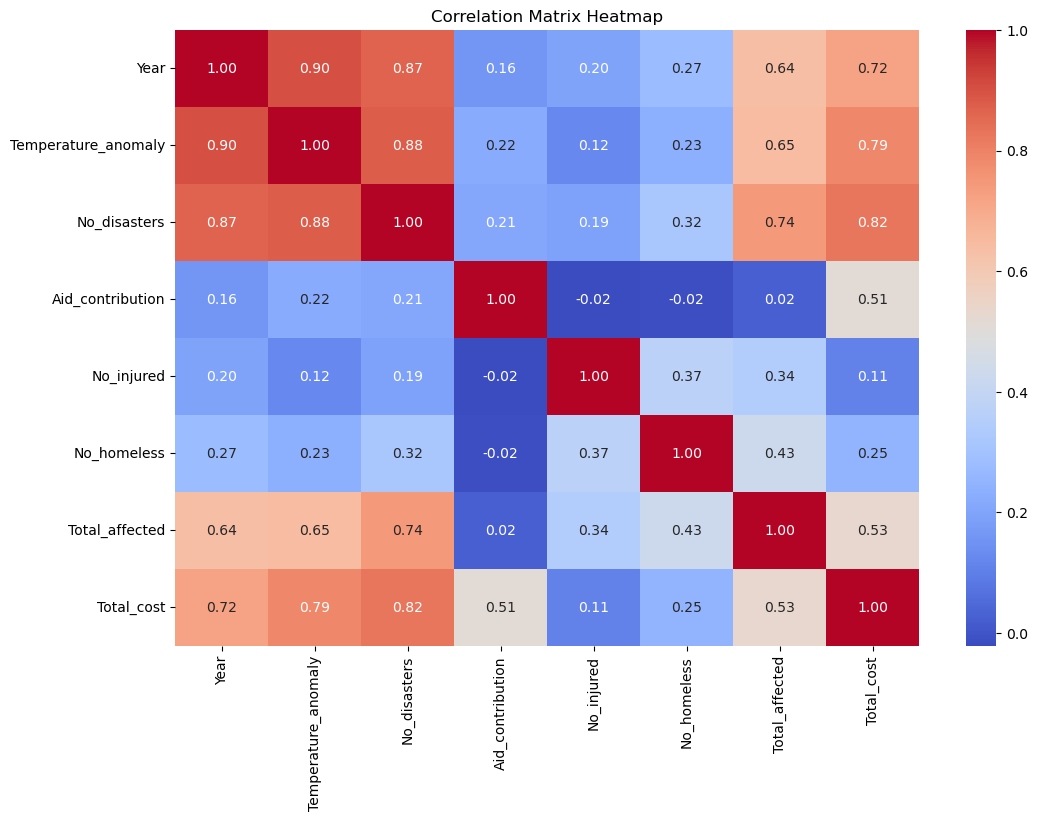

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix

numeric_data = year_df.select_dtypes(include=["number"])
correlation_matrix = numeric_data.corr()


# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,  # Annotate each cell with the correlation value
    fmt=".2f",   # Format to 2 decimal places
    cmap="coolwarm",  # Color map
    cbar=True     # Show color bar
)

# Add a title
plt.title("Correlation Matrix Heatmap")
plt.show()

Split into training and test data:

In [10]:
target = "Total_cost"
disasters.data = year_df
X_train, X_test, y_train, y_test = disasters.split_train_test(target)

In [ ]:
# Check the data types of X_train and X_test
print("Data types of X_train columns:")
print(X_train.dtypes)
print()

print("Data types of X_test columns:")
print(X_test.dtypes)

Scale the data:

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train, y_train, X_test, y_test = disasters.scale(scaler)

Create tensors:

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Create model:

In [13]:
# Define the model
model = nn.Sequential(
    nn.Linear(7, 13),
    nn.ReLU(),
    nn.Linear(13, 10),
    nn.ReLU(),
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train model:

In [14]:
#From https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
import numpy as np
import torch
import tqdm
import copy
from sklearn.model_selection import train_test_split

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train_tensor), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test_tensor)
    mse = loss_fn(y_pred, y_test_tensor)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

Some graphs to show results:

MSE: 0.17
RMSE: 0.42


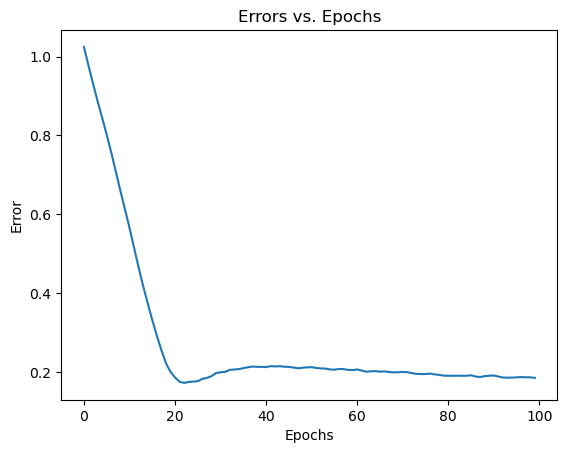

In [15]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.title("Errors vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.plot(history)
plt.show()

Mean Squared Error on Test Data: 0.17232291400432587
R-squared on Test Data: 0.8276770710945129


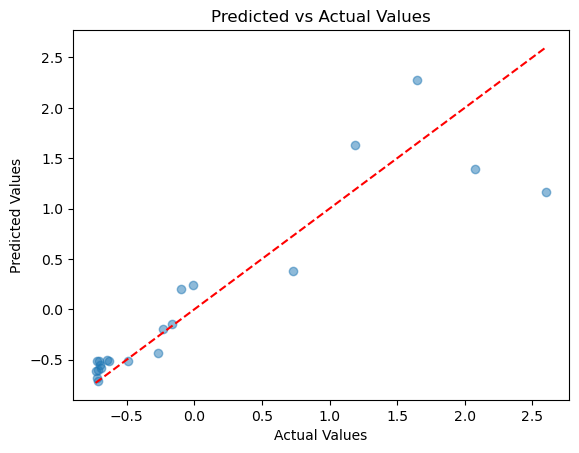

In [16]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for evaluation
    y_test_pred = model(X_test_tensor)

mse = loss_fn(y_test_pred, y_test_tensor)
print(f"Mean Squared Error on Test Data: {mse.item()}")

ss_total = torch.sum((y_test_tensor - torch.mean(y_test_tensor))**2)
ss_residual = torch.sum((y_test_tensor - y_test_pred)**2)
r_squared = 1 - (ss_residual / ss_total)
print(f"R-squared on Test Data: {r_squared.item()}")

import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for plotting
y_test_actual = y_test_tensor.numpy()
y_test_pred_np = y_test_pred.numpy()

plt.scatter(y_test_actual, y_test_pred_np, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

# Exploration of XGBoost on Climate Data

In [ ]:
disasters.data.head()

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

df = disasters.data

X = df.drop(columns=['Total_cost'])  # Features
y = df['Total_cost']  # Target

Scale the data:

In [22]:
X_train, X_test, y_train, y_test = disasters.split_train_test('Total_cost')

scaler = StandardScaler()
X_train, y_train, X_test, y_test = disasters.scale(scaler)


In [23]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=7, booster="gbtree")
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50,
       verbose=False)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.27808757153147856
R-squared: 0.7219124284685214


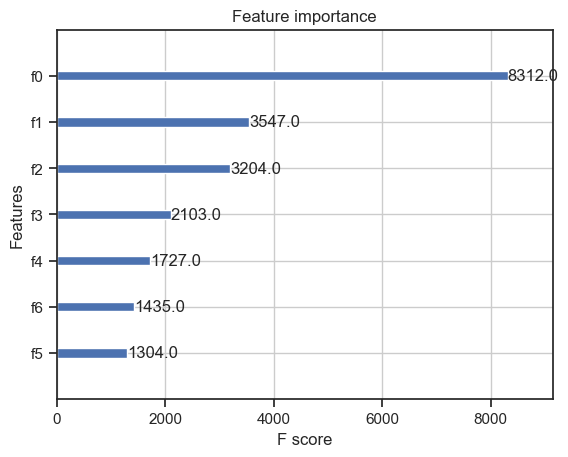

In [27]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plot_importance(model)
plt.show()


## Try a grid search

In [29]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 1000],
    'max_depth': [3, 5, 7, 20],
    'learning_rate': [0.001, 0.01, 0.1],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3
)

grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)

# Use the best estimator
best_model = grid_search.best_estimator_


{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000}


Use best model from GridSearch if wanted:

In [30]:
model = best_model

In [31]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.27808757153147856
R-squared: 0.7219124284685214


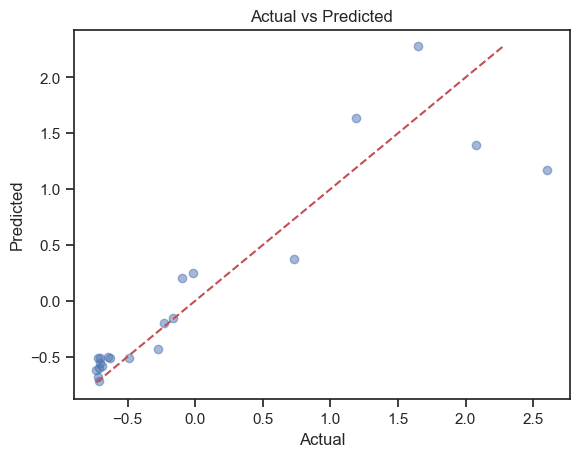

In [32]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for plotting
y_test_actual = y_test_tensor.numpy()
y_pred_np = y_test_pred.numpy()


plt.scatter(y_test_actual, y_pred_np, alpha=0.5)
plt.plot([y_test_actual.min(), y_pred_np.max()], [y_test_actual.min(), y_pred_np.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()


Plot predictions and actual data for total costs:

In [ ]:
disasters.data.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cost_by_year(df, year_column, cost_column, title, x_label="Year", y_label="Total Cost ('000 US$)", figsize=(14, 6)):

    # Aggregate the total cost of disasters per year
    cost_by_year = df.groupby(year_column)[cost_column].sum()
    
    # Initialize the figure
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)

    # Plot the total cost by year
    ax = sns.lineplot(x=cost_by_year.index, y=cost_by_year.values, marker="o", color="b")
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    ax.set_xticks(cost_by_year.index[::5])
    plt.xticks(rotation=45)
    plt.show()

plot_cost_by_year(
    df=disasters.data,                   # Your DataFrame
    year_column="Year",                  # The column for years
    cost_column="Total_cost", # The column containing the cost of disasters
    title="Total Cost of Disasters per Year"
)


In order to plot the predicted values vs actual, the predicted values must be descaled, using the same scaler I used to scale in the first place:

In [33]:
from sklearn.preprocessing import StandardScaler

y_pred = torch.tensor(y_pred)

# Rescale the predictions back to the original scale
y_pred_numpy = y_pred.cpu().detach().numpy()
descaled_predictions = scaler.inverse_transform(y_pred_numpy.reshape(-1, 1))

Then the values must be sorted by year to get a lined graph that makes sense:

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

x_values = disasters.X_test["Year"].values
y_values_test = disasters.y_test.values
y_values_pred = descaled_predictions.reshape(-1)

test = []
pred = []
for i, value in enumerate(x_values):
    pred.append((value, y_values_pred[i]))
    test.append((value, y_values_test[i]))

test.sort(key=lambda x: x[0])
pred.sort(key=lambda x: x[0])

x_values = [item[0] for item in test]
y_values_test = [item[1] for item in test]
y_values_pred = [item[1] for item in pred]

In [35]:
print(y_values_pred)

[8744688.0, 4184581.8, 6670958.0, 9005306.0, 10934702.0, 8693450.0, 7622054.0, 7009712.0, 7009712.0, 8596606.0, 8313418.0, 17146662.0, 18246838.0, 21697056.0, 28401468.0, 30805432.0, 59309896.0, 69821220.0, 77267800.0, 64033340.0, 69428590.0]


Finally, the plot of how the FFNN-model performed compared to the actual test data:

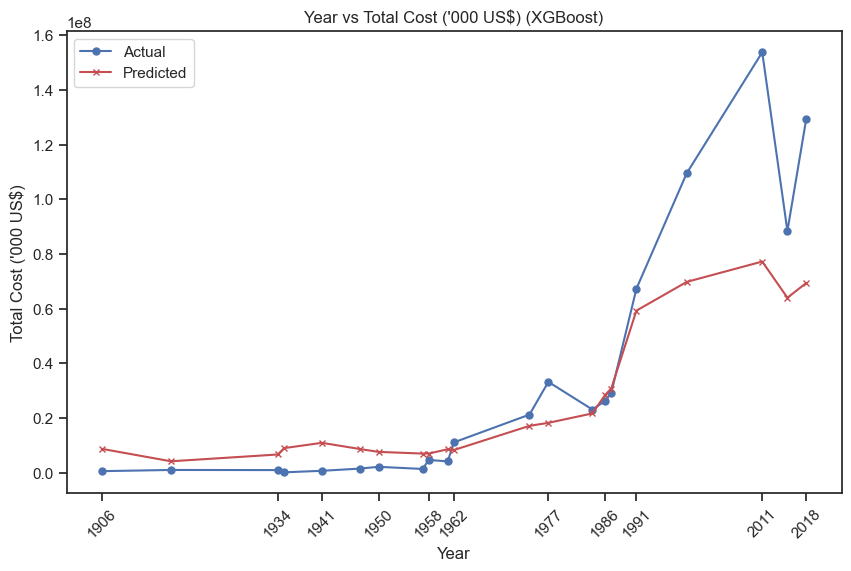

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the plot
plt.figure(figsize=(10, 6))
sns.set_theme(style="ticks", font_scale=1)

# Plot the actual data (y_values_test) vs years
plt.plot(x_values, y_values_test, label="Actual", color="b", marker="o", linestyle='-', markersize=5)

# Plot the predicted data (y_values_pred) vs years
plt.plot(x_values, y_values_pred, label="Predicted", color="r", linestyle='-', marker="x", markersize=5)

# Set labels and title
plt.xlabel("Year")
plt.ylabel("Total Cost ('000 US$)")  # Adjust as needed depending on the variable you're plotting
plt.title("Year vs Total Cost (\'000 US$) (XGBoost)")

# Add a legend to distinguish between the two lines
plt.legend()

plt.xticks(x_values[::2], rotation=45)

# Show the plot
plt.show()